In [2]:
import os
import os.path as path
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la

from src.structured_random_features.src.models.weights import V1_weights

# Packages for fft and fitting data
from scipy import fftpack as fft
from sklearn.linear_model import Lasso

# Package for importing image representation
from PIL import Image, ImageOps


In [3]:
# 1. Generate random V1 weights

numCell = 100
dim = (30, 30)
cellSize = 5
sparseFreq = 1

W = V1_weights(numCell, dim, cellSize, sparseFreq)

In [4]:
print(W.shape)

(100, 900)


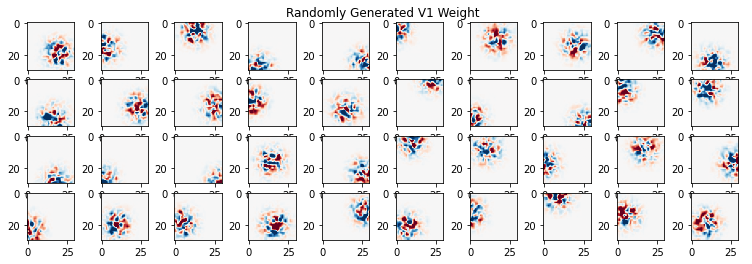

In [5]:
# 2. Plot those V1 weights

fig = plt.figure(figsize = (13, 4))
plt.title('Randomly Generated V1 Weight')
plt.axis('off')
for i in range(40):
    ax = fig.add_subplot(4, 10, i+1)
    cell_rf = W[i]
    cell_rf = cell_rf.reshape(dim)
    plt.imshow(cell_rf, cmap="RdBu")
    plt.clim([-3, 3])
    #plt.axis('off')

In [5]:
W.shape

(100, 900)

In [6]:
# Wx = (lambda)Ux * G
# min ||y-G(Lambda)s||^2 + lambda||s||.

In [7]:
# load size dim image
# reshape to dim[0] * dim[1]
# do:
#W @ x

(64, 104)


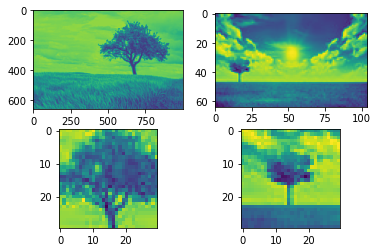

In [8]:
fig = plt.figure()

img_Original1 = Image.open("image/tree.jpg") # Original size(1000, 662)
img_Original1 = ImageOps.grayscale(img_Original1)

img_Original2 = Image.open("image/tree3.jpg") # Original size(64, 104)
img_Original2 = ImageOps.grayscale(img_Original2)
print(np.asarray(img_Original2).shape)

# took 30 X 30 pixel part of tree image at about coord(650, 260)
img1 = Image.open("image/tree_part1.jpg")
img1 = ImageOps.grayscale(img1)
imgArr1 = np.asarray(img1)


# Substitution image in case
img2 = Image.open("image/tree3_part.jpg")
img2 = ImageOps.grayscale(img2)
imgArr2 = np.asarray(img2)

# # of image
numImage = 2

#Show image
ax = fig.add_subplot(2, 2, 1)
plt.imshow(img_Original1)

ax = fig.add_subplot(2, 2, 2)
plt.imshow(img_Original2)

ax = fig.add_subplot(2, 2, 3)
plt.imshow(img1)

ax = fig.add_subplot(2, 2, 4)
plt.imshow(img2)

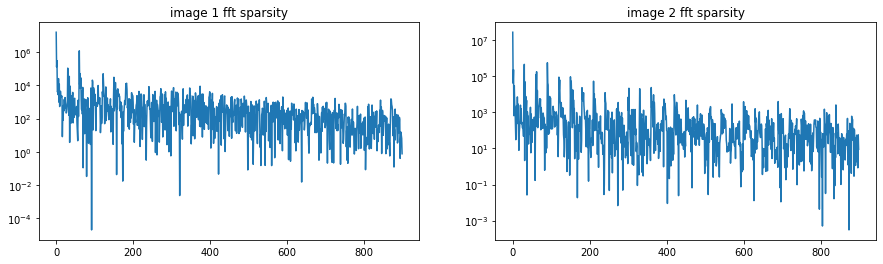

In [9]:
fig = plt.figure(figsize = (15, 4))

# FFT of original image
ax = fig.add_subplot(1, 2, 1)
plt.plot(fft.dctn(imgArr1, norm = 'ortho', axes=[0,1]).ravel() ** 2)
plt.title("image 1 fft sparsity")
ax.set_yscale('log')

ax = fig.add_subplot(1, 2, 2)
plt.plot(fft.dctn(imgArr2, norm = 'ortho', axes=[0,1]).ravel() ** 2)
plt.title("image 2 fft sparsity")
ax.set_yscale('log')

In [10]:
n = 30 # image in (n, n) dimension

imgArr1 = imgArr1.flatten().reshape((900, 1)) #flattens & resize image array into 1 dimension where (900, 1)
imgArr2 = imgArr2.flatten().reshape((900, 1)) #flattens & resize image array into 1 dimension where (900, 1)
print("ImgArr shape: ", imgArr1.shape)

ImgArr shape:  (900, 1)


Text(0.5, 1.0, 'image 2 fft sparsity')

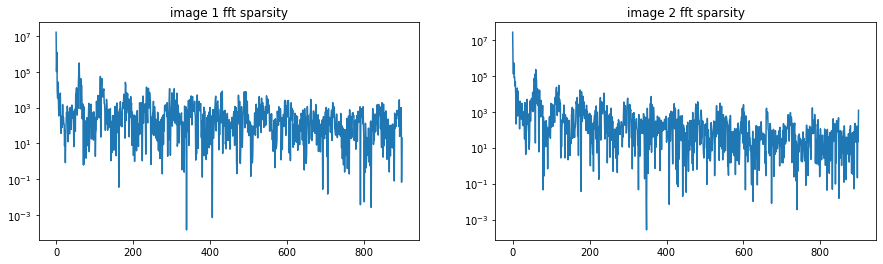

In [11]:
fig = plt.figure(figsize = (15, 4))

# FFT of original image
ax = fig.add_subplot(1, 2, 1)
plt.plot(fft.dctn(imgArr1, norm = 'ortho', axes = [0, 1]).ravel() ** 2)
plt.title("image 1 fft sparsity")
plt.yscale('log')

ax = fig.add_subplot(1, 2, 2)
plt.plot(fft.dctn(imgArr2, norm = 'ortho', axes = [0, 1]).ravel() ** 2)
plt.yscale('log')
plt.title("image 2 fft sparsity")

### Seems like it is sparse enough, Thus I will try to implement original fft onto it to see if it can generate original image

## From y = CΨs, (While considering W ~= C
#### 1.Get y
#### 2. Do WΨ to get theta
#### 3. Lasso to fit thetha with y and get sparse s
#### 4. Reconstruct image

In [26]:
# 1. Some measurement y

# image 1
y1 = W @ imgArr1
# y1 = y1.squeeze()
print(imgArr1.shape)
# image 2
y2 = W @ imgArr2
# y2 = y2.squeeze()
y1.shape

(900, 1)


(100, 1)

In [20]:
## 2. WΨ
theta = fft.dctn(W.reshape(numCell, n, n), norm = 'ortho', axes = [1, 2])
theta = theta.reshape(numCell, n*n)
theta.shape


(100, 900)

In [21]:
# Check difference between W and theta
#fig = plt.figure(figsize = (15, 4))
#ax = fig.add_subplot(1, 2, 1)
#plt.plot(theta)
#plt.title("Theta")

#ax = fig.add_subplot(1, 2, 2)
#plt.plot(W)
#plt.title("W")


s1 shape: (900,)
s2 shape: (900,)


Text(0.5, 1.0, 'sparse s2')

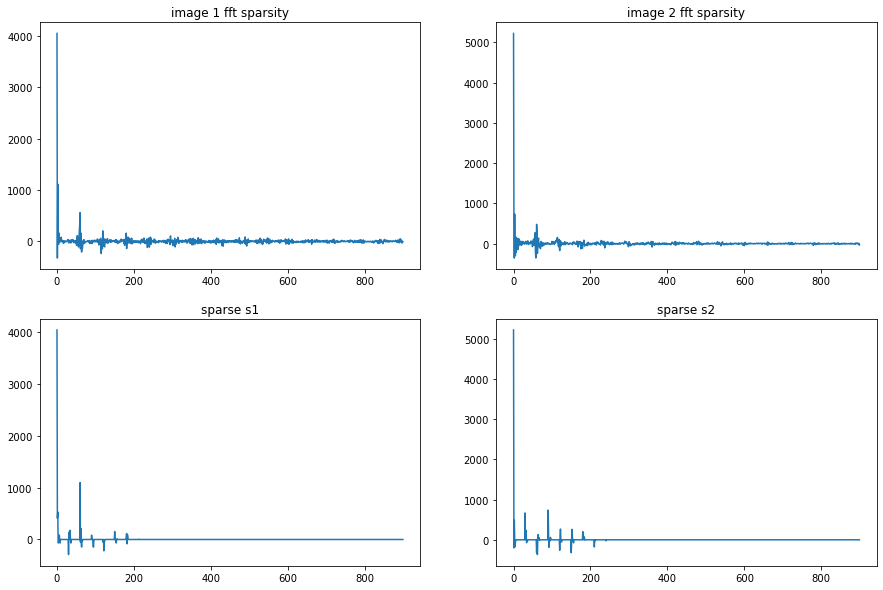

In [22]:


fig = plt.figure(figsize = (15, 10))

# FFT of original image
ax = fig.add_subplot(2, 2, 1)
plt.plot(fft.dctn(imgArr1, norm = 'ortho'))
plt.title("image 1 fft sparsity")

ax = fig.add_subplot(2, 2, 2)
plt.plot(fft.dctn(imgArr2, norm = 'ortho'))
plt.title("image 2 fft sparsity")

# Normalize data with lasso
mini = Lasso(alpha = 1*numCell)
mini.fit(theta, y1)
s1 = mini.coef_
print("s1 shape:", s1.shape)

ax = fig.add_subplot(2, 2, 3)
plt.plot(s1)
plt.title('sparse s1')

mini.fit(theta, y2)
s2 = mini.coef_
print("s2 shape:", s2.shape)

ax = fig.add_subplot(2, 2, 4)
plt.plot(s2)
plt.title('sparse s2')

In [23]:
# 4. Reform image
reform1 = fft.idctn(s1.reshape(n, n), norm='ortho', axes = [0, 1])
reform2 = fft.idctn(s2.reshape(n, n), norm='ortho', axes = [0, 1])

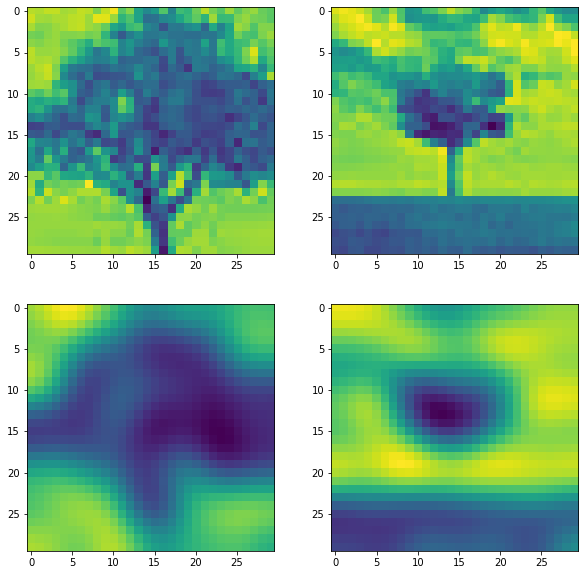

In [24]:
# Show Original/Reconstructed image
fig = plt.figure(figsize = (10, 10))

ax = fig.add_subplot(2, 2, 1)
plt.imshow(img1)

ax = fig.add_subplot(2, 2, 2)
plt.imshow(img2)

ax = fig.add_subplot(2, 2, 3)
plt.imshow(reform1)

ax = fig.add_subplot(2, 2, 4)
plt.imshow(reform2)

In [18]:
np.linalg.norm(img1 - reform1, 'fro') / n

25.144612135732945